In [2]:
main_dir = '/Users/simon/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pyxpcm
from pyxpcm.models import pcm
import run_throughs.sithom_plot_style as sps


def pcm_fit_and_post(time_i=42, K=4, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > 
                           max_depth).drop(['iter', 'Depth', 
                                            'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
        
    lons_new = np.linspace(both_nc.XC.min(), both_nc.XC.max(), 60*4)
    lats_new = np.linspace(both_nc.YC.min(), both_nc.YC.max(), 60)
    ds = both_nc # .copy(deep=True)
    #ds = both_nc.interp(coords={'YC': lats_new, 'XC': lons_new})#, method='cubic')
        
    m = pcm(K=K, features=features_pcm, 
            maxvar=maxvar, 
            #timeit=True, timeit_verb=1, 
            separate_pca=False)
    m.fit(ds, features=features, dim='Z')
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        #del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        #del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        # del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        del ds.IMETRIC.attrs['_pyXpcm_cleanable']
        del ds.A_B.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    ds = ds.drop(['THETA', 'SALT'])   
 
    return ds, m

def plot_so(xr_da):

    map_proj = ccrs.SouthPolarStereo()
    carree = ccrs.PlateCarree()

    fig = plt.figure(figsize=[5, 5])

    ax1 = plt.subplot(1, 1, 1, projection=map_proj)
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, 
                        wspace=0.02)
    ax1.set_extent([-180, 180, -90, -30], carree)
    
    def plot_boundary():
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.45
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax1.set_boundary(circle, transform=ax1.transAxes)
    
    plot_boundary()
    
    sps.ds_for_graphing(xr_da.to_dataset()).to_array().plot(
               transform=carree,                      # the data's projection
               ax=ax1,
               subplot_kws={"projection": map_proj},  # the plot's projection
               cbar_kwargs={"shrink": 0.3},
               )
    
    ax1.coastlines()
    """
    ax1.gridlines(xlocs=range(-int(xr_ds.XC.values.min()), 
                              int(xr_ds.XC.values.max()), 45), 
                  ylocs=range(-80, -19, 20))
                             
    """
    
    #plt.savefig('i_metric_example.pdf')

    
def pair_i_metric(ds):
    
    sorted_version = np.sort(ds.A_B.values, axis=0)

    i_metric = ds.IMETRIC.isel(Imetric=0).values


    list = [i for i in range(int(np.nanmax(sorted_version)) + 1)]

    cart_prod = [np.array([a, b]) for a in list for b in list if a <= b and a != b]

    pair_i_metric_list = []

    pair_list = []

    for pair in cart_prod:

        print(pair)
        print(pair[0])
        print(pair[1])
        shape = np.shape(sorted_version)

        pair_i_metric = np.empty((shape[1], shape[2],))
        pair_i_metric[:] = np.nan

        at_least_one_point = False

        for i in range(shape[1]):
            for j in range(shape[2]):
                if np.array_equal(pair, sorted_version[:, i, j]):
                    if i_metric[i, j] >= 0.5:
                        pair_i_metric[i, j] = i_metric[i, j]
                        at_least_one_point = True

        if at_least_one_point:

            pair_i_metric_list.append(pair_i_metric)
            pair_list.append(pair)


    pair_i_metric_array = np.zeros([len(pair_i_metric_list), shape[1], shape[2]])

    for i in range(len(pair_i_metric_list)):
        pair_i_metric_array[i, :, :] = pair_i_metric_list[i][:, :]
        
    pair_str_list = []

    for i in range(len(pair_list)):
        pair_str_list.append( str(pair_list[i][0]) + ' to ' + str(pair_list[i][1]))

    da = xr.DataArray(pair_i_metric_array,
                      dims=['pair', 'YC', 'XC'],
                      coords={'XC': ds.coords['XC'].values,
                              'YC': ds.coords['YC'].values,
                              'pair': pair_str_list})
    
    return da

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ds, m = pcm_fit_and_post(time_i=42, K=4, maxvar=2)

features_dict {'THETA': 'THETA', 'SALT': 'SALT'}
Fitting PCA
[(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]
features_dict {'THETA': 'THETA', 'SALT': 'SALT'}
(800124, 2)


In [8]:
da = pair_i_metric(ds)

[0 1]
0
1
[0 2]
0
2
[0 3]
0
3
[1 2]
1
2
[1 3]
1
3
[2 3]
2
3


In [9]:
da

<xarray.DataArray (pair: 4, YC: 588, XC: 2160)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * pair     (pair) <U6 '0 to 1' '0 to 2' '1 to 2' '1 to 3'

/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


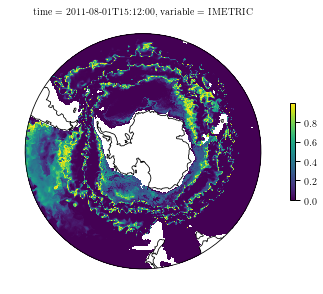

In [5]:
plot_so(ds.IMETRIC.isel(Imetric=0))


In [18]:
for var in ds.variables:
    if var in ['I_METRIC', 'A_B']:
        ds.variables[var]

In [32]:
ds.I_METRIC.isel(Imetric=0)

<xarray.DataArray 'I_METRIC' (YC: 60, XC: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * YC       (YC) float64 -77.98 -77.16 -76.35 -75.53 ... -31.35 -30.53 -29.72
  * XC       (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Attributes:
    long_name:  I metric
    units:      
    valid_min:  0
    valid_max:  1

In [31]:
ds.I_METRIC.isel(Imetric=0)

<xarray.DataArray 'I_METRIC' (YC: 60, XC: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * YC       (YC) float64 -77.98 -77.16 -76.35 -75.53 ... -31.35 -30.53 -29.72
  * XC       (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Attributes:
    long_name:  I metric
    units:      
    valid_min:  0
    valid_max:  1

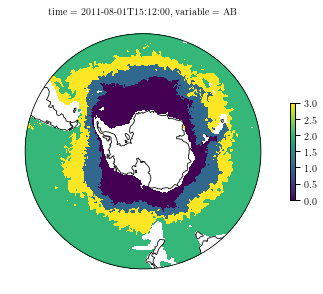

In [5]:
plot_so(ds.A_B.rename('AB').isel(rank=0))


/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


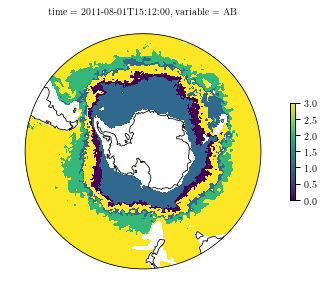

In [4]:
plot_so(ds.A_B.rename('AB').isel(rank=1))


In [3]:
ds

<xarray.Dataset>
Dimensions:  (Imetric: 1, XC: 2160, YC: 588, Z: 52, rank: 2)
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
Dimensions without coordinates: Imetric, rank
Data variables:
    IMETRIC  (Imetric, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    A_B      (rank, YC, XC) float64 nan nan nan nan nan ... 3.0 3.0 3.0 3.0 3.0

In [6]:
da

<xarray.DataArray (pair: 4, YC: 588, XC: 2160)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * pair     (pair) <U6 '0 to 1' '0 to 2' '1 to 2' '1 to 3'

In [7]:
np.shape(ds.A_B.values)

(2, 588, 2160)

In [10]:
sorted_version[:, 530, 2100]

array([2., 3.])

In [16]:
np.nanmax(sorted_version)

3.0

In [17]:
np.nanmin(sorted_version)

0.0

[0 1]
0
1


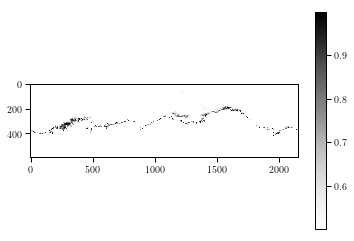

[0 2]
0
2
[0 3]
0
3


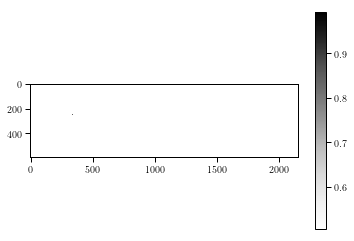

[1 2]
1
2
[1 3]
1
3


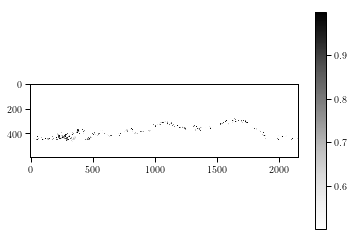

[2 3]
2
3


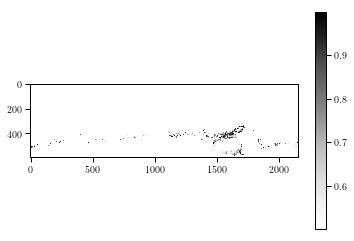

<Figure size 432x288 with 0 Axes>

In [47]:

def great_stuff():
    
    sorted_version = np.sort(ds.A_B.values, axis=0)

    i_metric = ds.IMETRIC.isel(Imetric=0).values


    list = [i for i in range(int(np.nanmax(sorted_version)) + 1)]

    cart_prod = [np.array([a, b]) for a in list for b in list if a <= b and a != b]

    pair_i_metric_list = []

    pair_list = []

    for pair in cart_prod:

        print(pair)
        print(pair[0])
        print(pair[1])
        shape = np.shape(sorted_version)

        pair_i_metric = np.empty((shape[1], shape[2],))
        pair_i_metric[:] = np.nan

        at_least_one_point = False

        for i in range(shape[1]):
            for j in range(shape[2]):
                if np.array_equal(pair, sorted_version[:, i, j]):
                    if i_metric[i, j] >= 0.5:
                        # print(pair, sorted_version[:, i, j])
                        pair_i_metric[i, j] = i_metric[i, j]
                        at_least_one_point = True

        if at_least_one_point:

            pair_i_metric_list.append(pair_i_metric)
            pair_list.append(pair)

            plt.imshow(pair_i_metric, cmap='Greys'
                      )
            plt.colorbar()
            plt.show()
            plt.clf()


    pair_i_metric_array = np.zeros([len(pair_i_metric_list), shape[1], shape[2]])

    for i in range(len(pair_i_metric_list)):
        pair_i_metric_array[i, :, :] = pair_i_metric_list[i][:, :]

    da = xr.DataArray(pair_i_metric_array,
                      dims=['pair', 'YC', 'XC'],
                      coords={'XC': ds.coords['XC'].values,
                              'YC': ds.coords['YC'].values,
                              'pair': pair_str_list})
    
    return da


In [27]:
shape = np.shape(sorted_version)

In [28]:
shape

(2, 588, 2160)

In [32]:
a = np.empty((3,3,))
a[:] = np.nan
a

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [35]:
np.shape(i_metric)

(588, 2160)

In [45]:
pair_list

NameError: name 'pair_list' is not defined

In [46]:
pair_i_metric_list

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

In [48]:
pair_list

[array([0, 1]), array([0, 3]), array([1, 3]), array([2, 3])]

In [56]:
#X, sampling_dims = self.preprocessing(ds, features=features, dim=dim, action=action, mask=mask)
#pca_values = X.values
#n_features = str(X.coords['n_features'].values)
P = []

for i in range(len(pair_i_metric_list)):
    X = xr.DataArray(pair_i_metric_list[i],
                     dims=['YC', 'XC'],
                     coords={'XC': ds.coords['XC'].values,
                             'YC': ds.coords['YC'].values})
    # x = m.unravel(ds, ['XC', 'YC'], pair_i_metric_list[i])
    P.append(X)

da = xr.concat(P, dim='pair').rename('I_METRIC')

#da.attrs['long_name'] = 'PCA Values'
#da.attrs['n_features'] = n_features

# ds.coords.values

# Add posteriors to the dataset:


In [83]:
pair_i_metric_array = np.zeros([len(pair_i_metric_list), shape[1], shape[2]])

for i in range(len(pair_i_metric_list)):
    pair_i_metric_array[i, :, :] = pair_i_metric_list[i][:, :]
    
da = xr.DataArray(pair_i_metric_array,
                  dims=['pair', 'YC', 'XC'],
                  coords={'XC': ds.coords['XC'].values,
                          'YC': ds.coords['YC'].values,
                          'pair': pair_str_list})

In [60]:
shape

(2, 588, 2160)

In [62]:
len(pair_list)


4

In [82]:
pair_str_list = []

for i in range(len(pair_list)):
    pair_str_list.append(str(pair_list[i][0]) + ' to ' + str(pair_list[i][1])) #.tolist())
    #    print(test)    
    # pair_str_list.append("{:} to {:}".format(pair_list[i]))
    
print(pair_str_list)

['0 to 1', '0 to 3', '1 to 3', '2 to 3']


In [73]:
str(pair_list[0][0])

'0'

In [84]:
da

<xarray.DataArray (pair: 4, YC: 588, XC: 2160)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * pair     (pair) <U6 '0 to 1' '0 to 3' '1 to 3' '2 to 3'

/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [

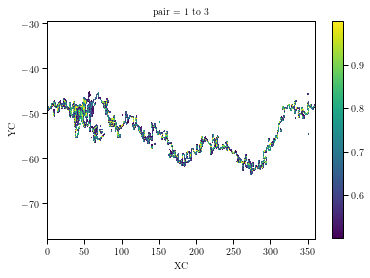

In [85]:
da.isel(pair=2).plot()

/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


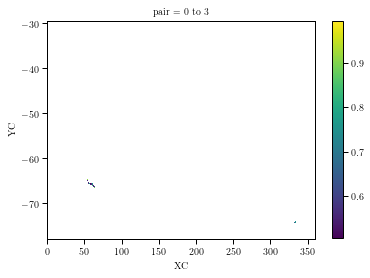

In [86]:
da.isel(pair=1).plot()

/Users/simon/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


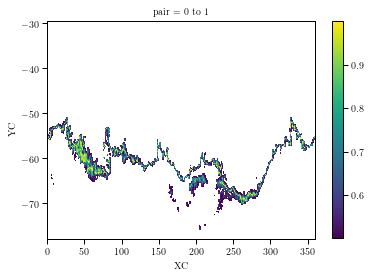

In [87]:
da.isel(pair=0).plot()

In [89]:
ds1 = da.to_dataset(name='imetric')

In [90]:
ds1

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 588, pair: 4)
Coordinates:
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * pair     (pair) <U6 '0 to 1' '0 to 3' '1 to 3' '2 to 3'
Data variables:
    imetric  (pair, YC, XC) float64 nan nan nan nan nan ... nan nan nan nan nan

ValueError: unable to convert unnamed DataArray to a Dataset without providing an explicit name

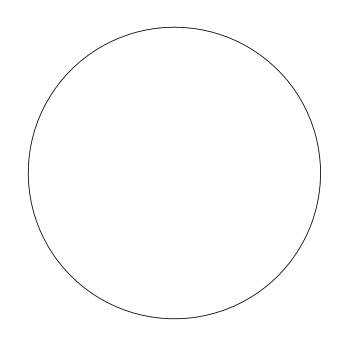

In [12]:
plot_so(da.isel(pair=1))

In [7]:
ds

<xarray.Dataset>
Dimensions:  (Imetric: 1, XC: 2160, YC: 588, Z: 52, rank: 2)
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * XC       (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float64 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
Dimensions without coordinates: Imetric, rank
Data variables:
    IMETRIC  (Imetric, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    A_B      (rank, YC, XC) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0